In [ ]:
'''
Nota: Antés de correr el programa asegurarse de tener instalado ipywidgets y usar el comando:

jupyter nbextension enable --py widgetsnbextension 

para el adecuado funcionamiento de este programa

'''

# Introducción 

En el presente proyecto se realiza una aplicación interactiva 
que permita visualizar el espectro de radiación de un cuerpo conforme se varía
la temperatura de este, graficando la intensidad en función de la longitud de onda.
Además, se genera una pequeña aplicación interactiva en la cual el usario
puede variar la temperatura del cuerpo negro y un rango de longitudes de onda para 
saber la intensidad
en ese intervalo.



In [1]:
#Librerías útiles para los cálculos

import numpy as np
import scipy.integrate as integrate
import scipy.optimize as optimize

In [2]:
#parámetros 

c=3e8 #Velocidad de la luz [m/s]
h=6.63e-34 #Constante de Plank [J*s]
k=1.38e-23 #Constante Boltzman [J/K]
params=[c,h,k]

# Marco teórico 

### Variables que se usarán:

$\lambda: Longitud \ de \ onda \ (nanómetros) $

$T: Temperatura \ absoluta \ (Kelvin) $

$c: Velocidad \ de \ la \ luz = 3x10^8 \  \frac{metros}{segundos} $

$h: Constante \ de \ Plank = 6.63x10^{-34} \ Joules*segundos $

$k= Constante \ de \ Boltzman = 1.38x23 \ \frac{Joules}{Kelvin} $



## Ley de desplazamiento de Wein (Posición máximo de radiación)

La longitud de onda con el máximo de radiación asociado de un cuerpo negro la podemos hallar calculando la primera derivada de la distribución de Plank en terminos de la longitud de onda:

$$ \frac {d} {d\lambda} \left(
\frac{1}{\lambda^5 (e^{\frac{hc}{\lambda_m k T}}-1)}\right) = 0 \ (1)$$

Obteniendo la ecuación trascendental:

$$5(e^x - 1) - xe^x =0  \ (2)$$ 

con: $$x=\frac{hc}{\lambda_m k T} \ (3)$$

Hallamos la raíz de la ecuación $(1)$ usando `scipy.optimize.newton`:


In [3]:
def Eq(z):
    return 5*(np.exp(z)-1) - z*np.exp(z)

z=np.round(optimize.newton(Eq,5),3)

Ahora con el valor de $x$ podemos resolver para $\lambda_m$ la euación $(3)$:

$$\lambda_m =\frac{hc}{kTx} \ (4)$$

In [4]:
def λm(T,args=(params,)):
    return h*c/(k*z*T)

## Ley de Stefan-Boltzman (Intensidad)

La intensidad de onda por unidad de onde de un cuerpo negro está dada por:

$$ \frac {dW_\lambda} {d\lambda}= \frac{2 \pi h c^2}{\lambda^5 (e^{\frac{hc}{\lambda_m k T}}-1)}  \ (5)$$

In [5]:
def dW_dλ(λ,T,args=(params,)):
    return 2*np.pi*h*(c**2)/((λ**5)*(np.exp(h*c/(λ*k*T))-1))

Para calcular la intensidad total de la radiación que emite un cuerpo negro integramos la ecuación $(5)$ para todas las longitudes de ondas:

$$W = \int\limits_0^\infty dW_\lambda = \int\limits_0^\infty \frac{2 \pi h c^2}{\lambda^5 (e^{\frac{hc}{\lambda_m k T}}-1)}  \ (6)$$ 

haciendo el cambio de variable en ecuación $(6)$: $x=\frac{hc}{\lambda k T}$

obtenemos la ecuación:
$$W= \frac{2 \pi k^4 T^4}{c^2 h^3} \int\limits_0^\infty \frac{x^3}{e^x -1}dx \ (7)  $$

La cual resolvemos usando `integrate.quad`: 

In [6]:
def F(x):
    return x**3/(np.exp(x)-1)
    
def W(λ1,λ2,T,args=(params,)):
    x1=h*c/(k*T*λ2)
    x2=h*c/(k*T*λ1)
    C=2*np.pi*(k**4)*(T**4)/((c**2)*(h**3))
    return C*integrate.quad(F,x1,x2)[0]

def W_total(T):
    return np.round(W(1e-8,np.inf,T),0)    

Cambiando límites de integración de ecuación $(7)$ podemos hallar también la intensidad total entre dos longitudes de onda deseadas:

$$W= \frac{2 \pi k^4 T^4}{c^2 h^3} \int\limits_ {x_1}^{x_2} \frac{x^3}{e^x -1}dx \ (8)  $$

# Gráficas y resultados

In [7]:
#Librerías útiles para las aplicaciones interactivas

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib nbagg

**Deslize el cursor de la parte superior para cambiar la temperatura del cuerpo negro 
y observar el cambio en la grafica intensidad vs longitud de onda


<IPython.core.display.Javascript object>


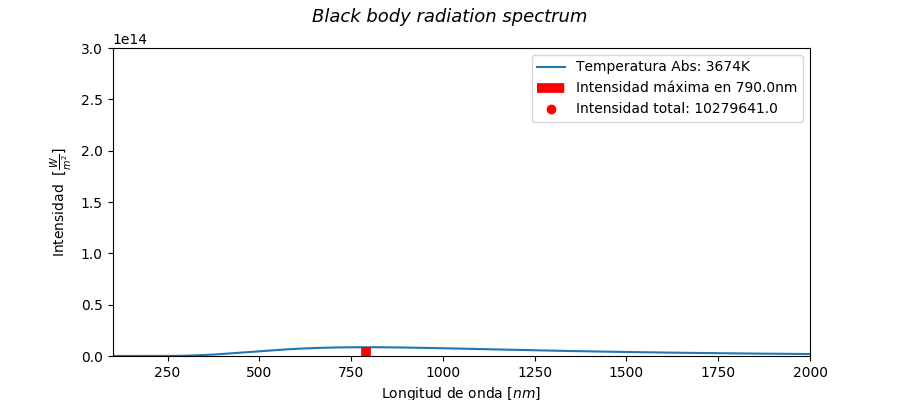

In [8]:
print('''**Deslize el cursor de la parte superior para cambiar la temperatura del cuerpo negro 
y observar el cambio en la grafica intensidad vs longitud de onda''')

λ=np.linspace(100e-9,2000e-9,1000) #Genera un arreglo con longitudes de onda
fig, ax = plt.subplots(1, figsize=(9, 4))#Crea lienzo para graficar
plt.suptitle('Black body radiation spectrum', size=13, style='italic' )



def update_plot(S): #Se define grafica con la que se pueda interactuar posteriormente 
    
    ax.clear() #limpia el lienzo cuando se cambia la temperatura con slider 
    λmax=λm(S) #Calcula la posición del máximo con ecuación (4)
    
    #Este bloque genera un rango de colores de acuerdo a la longitud de onda
    
    if 390 <= λmax*1e9 <= 430:
        color='purple'
    
    if 430 <= λmax*1e9 <= 450:
        color='violet'
        
    if 450 <= λmax*1e9 <= 480:
        color='blue'
    
    if 480 <= λmax*1e9 <= 530:
        color='green'
    
    if 530 <= λmax*1e9 <= 580:
        color='yellow'
    
    if 580 <= λmax*1e9 <= 640:
        color='orange'
        
    if 640 <= λmax*1e9 <= 800:
        color='red'

    
    
    ax.plot(λ*1e9, dW_dλ(λ,S), 
    label='Temperatura Abs: {}K'.format(S)) #Gráfico intensidad vs longitud de onda
    
    ax.plot((λmax*1e9,λmax*1e9),
    (0,dW_dλ(λmax,S)),'--',color=color, lw=7,
    label='Intensidad máxima en {}nm'.format(np.round(λmax*1e9),2))#Longitud de onda donde la intensidad es máxima 
    

    ax.plot(0,0,'ro',label='Intensidad total: {}'.format(W_total(S)))#Muestra la intensidad total radiada
    
    

    ax.set_xlim(λ[0]*1e9, λ[-1]*1e9) #Límites en x
    ax.set_ylim(0, 3e14) #Límites en y
    ax.legend(loc=1) #Ubicación cuadro leyenda
    plt.xlabel('Longitud de onda [$nm$]', size=10)
    plt.ylabel(r'Intensidad  [$\frac{W}{m^2}$]', size=10)
    plt.show()


S = widgets.IntSlider(min=3674, max=7400, value=5500, description='Temperatura Abs.(K):'
    ,layout=widgets.Layout(width='50%', height='50%',left='True'))#Genera un slider para intereactuar con gráfico
    
widgets.interactive(update_plot, S=S) #Genera la interacción con el gráfico


In [ ]:
#Codigo para calcular intensidad entre dos longitudes de onda deseadas, variando temperatura

print('''**Deslize sliders para modificar intervalo 
de longitud de onda y temperatura del cuerpo negro''')

def update_function(M,R): #Se define función con la que se pueda interactuar posteriormente 
    
    a=np.round(W(M[0]*1e-9,M[-1]*1e-9,R),2)
    print(r'La intensidad entre {}nm y {}nm es: {} W/m^2'.format(M[0],M[-1],a))
    

M = widgets.FloatRangeSlider(min=392, max=790, value=[500,600], description='Longitud onda(nm):',layout=widgets.Layout(width='50%', height='50%',left='True'))
R = widgets.IntSlider(min=3674, max=7400, value=5500, description='Temperatura Abs(K):',layout=widgets.Layout(width='50%', height='50%'))


widgets.interactive(update_function, R=R, M=M)

# Bibliografía y cibergrafía 

[1] La radiación del cuerpo negro: http://www.sc.ehu.es/sbweb/fisica/cuantica/negro/radiacion/radiacion.htm

[2] Learn Jupyter Notebooks (pt.4) Using Interactive Widgets: https://www.youtube.com/watch?v=SN0Bflf14C4

[3] Widgets_example.ipynb:https://github.com/markjay4k/fourier-transform/blob/master/widgets_example.ipynb 

[4] Sears Zemansky, Física universitaria 12 ed, Vol 2 . Pag 1336-1337

[5] Black body radiation simulation: http://physics.bu.edu/~duffy/classroom.html 


